# Packages

In [316]:
!pip install lime
# basic packages
from time import time

# basic data processing packages
import numpy as np
from numpy import random
import pandas as pd

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# machine learning packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os, json
import torchvision
from torchvision import models, transforms
from torch.autograd import Variable

# LIME packages
import lime
from lime import lime_image



# Predefined functions

In [317]:
def single_img_plot(X,y=10):
#     X = np.reshape(X, (28,28))
    plt.imshow(X)
    plt.colorbar()
    plt.title('MNIST random check, label %d' %y)
    plt.show()

# Loading data

In [216]:
train_images_fn = './data/train_images.npy'
train_images = np.load(train_images_fn)/255 # normalization
train_images = np.reshape(train_images,(len(train_images),28,28)) # reshape for pytorch tensor
train_labels_fn = './data/train_labels.npy'
train_labels = np.load(train_labels_fn) 

test_images_fn = './data/test_images.npy'
test_images = np.load(test_images_fn)/255 
test_images = np.reshape(test_images,(len(test_images),28,28))
c_fn = './data/test_labels.npy'
test_labels = np.load(test_labels_fn)

print('Train data dim:', train_images.shape, train_labels.shape)
print('Test data dim:', test_images.shape, test_labels.shape)

Train data dim: (60000, 28, 28) (60000, 1)
Test data dim: (10000, 28, 28) (10000, 1)


### Shuffle data

In [191]:
idx_shuffle = np.arange(len(train_images))
random.shuffle(idx_shuffle)
train_images = np.array(train_images)[idx_shuffle]
train_labels = np.array(train_labels)[idx_shuffle]

idx_shuffle = np.arange(len(test_images))
random.shuffle(idx_shuffle)
test_images = np.array(test_images)[idx_shuffle]
test_labels = np.array(test_labels)[idx_shuffle]

### Visualization

57226


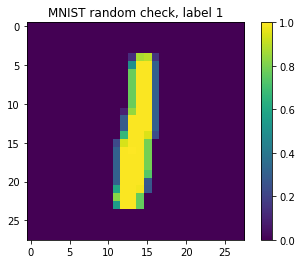

In [214]:
i = random.randint(len(train_images))
single_img_plot(train_images[i],train_labels[i])
# print(np.mean(train_images[i]))

# Arrange Pytorch
## Follow LIME on Pytorch tutorial but fail

### Convert image to pytorch tensor

In [151]:
# transfter np.ndarray to tensor
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.5, 0.5],
                                    std=[0.2, 0.2])       
    transf = transforms.Compose([
#         transforms.Resize((256, 256)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Load the pretrained model for Resnet50 (I tried AlexNet) available in Pytorch.

In [113]:
# model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /Users/xiaoweige/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Reload data

In [149]:
idx2label, cls2label, cls2idx = [], {}, {}
class_idx = np.arange(0,10)

cls2label = {str(class_idx[k]): class_idx[k] for k in range(len(class_idx))}
print(cls2label)

# with open(os.path.abspath('./data/imagenet_class_index.json'), 'r') as read_file:
#     class_idx = json.load(read_file)
#     idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
#     cls2label = {str(class_idx[k]): class_idx[k] for k in range(len(class_idx))}
#     cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))} 

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


## Build simple neural network using pytorch on MNIST

### Hyperparameters

In [318]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Convert np array to tensor (not used)
(seems hard to be consistent with the following codes)

The dimension of the tensor is:  torch.Size([60000, 1, 28, 28])


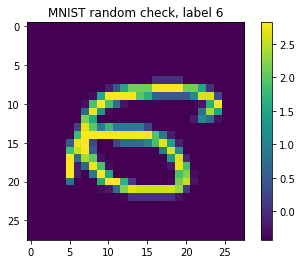

Output tensor mean check:  tensor(-0.0001, dtype=torch.float64)
Output tensor length check:  60000


In [271]:
# transfter np.ndarray to tensor
def get_input_transform():
    normalize = transforms.Normalize(mean = 0.1307, std = 0.3081)    # global mean and standard deviation   
    transf = transforms.Compose([
#         transforms.Resize((28, 28)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)
    return transf(img)

# print(train_images.shape)

train_images_tensors = get_input_tensors(train_images)
# it is weird that after transfering nparray to tensor, the dimension fliped and swopped
train_images_tensors = train_images_tensors.permute(2,0,1,3)
train_images_tensors = train_images_tensors.flip(3)

print('The dimension of the tensor is: ', train_images_tensors.shape)

single_img_plot(np.squeeze(train_images_tensors[i,:,:,:]),train_labels[i])

# check the mean
print('Output tensor mean check: ', torch.mean(train_images_tensors,dim = [0,1,2,3]))

print('Output tensor length check: ', len(train_images_tensors))

### Use Pytorch data loader to load MNIST data

In [396]:
# n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [341]:
# download and transform train dataset

from torchvision import datasets, transforms
from torch.autograd import Variable

train_loader = torch.utils.data.DataLoader(datasets.MNIST(root = './', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=batch_size_train,
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(datasets.MNIST(root = './', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=batch_size_test,
                                           shuffle=True)




### Data check plot

In [350]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print('Output tensor size check: ', example_data.shape)

Output tensor size check:  torch.Size([64, 1, 28, 28])


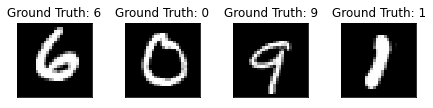

In [366]:
fig = plt.figure()
for i in range(4):
    idx_rand = random.randint(len(example_data))
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.imshow(example_data[idx_rand][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[idx_rand]))
    plt.xticks([])
    plt.yticks([])


### Build 2D CNN + 2 fully connected layer networks

In [397]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [398]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

### Train the model

In [377]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [378]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [403]:
n_epochs = 1
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [404]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-397-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3053, Accuracy: 1175/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.345277
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314412
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.293312
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.247632
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.299362
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.244425
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.267763
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.238738
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.171534
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.226693
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.115720
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.037859
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.020355
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.915638
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.821012
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.457798
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.553698
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.561154
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.305184
Train Epoch: 1 [12160

Text(0, 0.5, 'negative log likelihood loss')

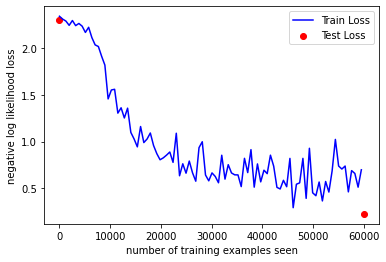

In [405]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:
for data, target in test_loader:
      output = network(data)
output_idx = torch.argmax(output,dim=1)

cf_mat = confusion_matrix(target,output_idx)
sns.set(font_scale=1)
sns.heatmap(cf_mat,annot = True,cmap = 'YlGnBu', fmt='d', 
            xticklabels = np.arange(0,10), yticklabels = np.arange(0,10))

sns.reset_orig

[0.09502839431762695, 0.08068327331542968]
[0, 60000, 120000, 180000]
